1. This script processes genotype data from Aldy4. It generates "allele_df_for_set123", which will be the target data of the prediction model. (matrix : row-person_id, col-star_allele, value-the number of allele)


2. This script conducts statistical test on the alleles types which are included in all SAMPLE_SET_1, SAMPLE_SET_2, SAMPLE_SET_3, and SAMPLE_SET_4. 

# Check Output

In [1]:
# !ls aldy_output > aldy_output_file.txt

In [2]:
with open('aldy_output_file.txt', 'r') as file:
    a = file.readlines()

# check the number of files created
p = [] # person id
g = [] # gene
for file in a[0:len(a)-1]:
    p.append(int(file[0:7]))
    g.append(file[8:].strip(".aldy\n"))
    
print("processed # of person id:", len(set(p)))
    
# check if person id : gene pair
for person in p:
    if p.count(person) != 5:
        print(person,":",p.count(person))


processed # of person id: 2283
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
1948725 : 11
9454296 : 4
9454296 : 4
9454296 : 4
9454296 : 4


In [3]:
import os
import os.path
import pandas as pd
import numpy as np
import itertools

In [4]:
# load random sample data set

my_dataframe_1 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_1/SAMPLE_SET_1.csv", header = 0).astype(int)
my_dataframe_1 = my_dataframe_1.dropna()  

my_dataframe_2 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_2/SAMPLE_SET_2.csv", header = 0, index_col = 0)
my_dataframe_2 = my_dataframe_2.dropna()  

my_dataframe_3 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_3/SAMPLE_SET_3.csv", header = 0, index_col = 0)
my_dataframe_3 = my_dataframe_3.dropna()  

my_dataframe_4 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_4/SAMPLE_SET_4.csv", header = 0, index_col = 0)
my_dataframe_4 = my_dataframe_4.dropna()  

my_dataframe_1 = my_dataframe_1.astype(int)
my_dataframe_2 = my_dataframe_2.astype(int)
my_dataframe_3 = my_dataframe_3.astype(int)
my_dataframe_4 = my_dataframe_4.astype(int)

In [5]:
# Variable assignment
# Merge data from three dataset into one

global PATH

PATH = "/home/jupyter/workspaces/multiallelicgenesinvestigation/aldy_output/"

PERSON_ID_1 = my_dataframe_1['person_id'].tolist()
PERSON_ID_2 = my_dataframe_2['person_id'].tolist()
PERSON_ID_3 = my_dataframe_3['person_id'].tolist()
PERSON_ID_4 = my_dataframe_4['person_id'].tolist()

# Compare <sample list> & <downloaded samples in aldy_output (p)>
PERSON_ID_all = list(set(PERSON_ID_1 + PERSON_ID_2 + PERSON_ID_3 + PERSON_ID_4).intersection(p))
print(len(PERSON_ID_all))

2283


In [7]:
# ######## writing #########
# df = pd.DataFrame(PERSON_ID_all,columns = ["person_id"])
# df.to_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/sample_id_for_set1234.csv")

# Major allele extracting

In [9]:
import re
import math


def allele_extract(ID,line): # Solution 1: *(1.018 +rs548264542 +rs28371721), *(2.019 +rs548264542 +rs28371721 -rs12169962 -rs28633410), *(2.019 -rs12169962 -rs28633410)
    str_numbers = re.findall("\d+.\d+",line)
    
    #check if there is "#" included allele
    sharp = []
    for s in str_numbers:
        if '#' in s:
            sharp.append(s)
            
    if sharp != []: # "#" 들어가는 item이 있는 경우
        print(ID,":",sharp)
        for item in sharp:
            str_numbers.remove(item)
        
    flt_numbers = [float(value) for value in str_numbers] #문자열에서 숫자만
    
    star_alleles = [] #major allele type
    rs = []

    for num in flt_numbers:
        if num - math.floor(num)>0: #major allele
            star_alleles.append(num)
        else:
            rs.append("rs"+str(num)) #+/-rs
            
    return star_alleles, rs
    

In [10]:
from pathlib import Path

### Allele Types in Dictionary

# ================================================================================

#  star_dict {"person_id" : [star_allele_1, star_allele_2, star_allele_3, ... ]}
#  star_dict {"person_id" : [rs_position_1, rs_position_2, rs_position_3, ... ]} 
#       or  {"person_id" : []} // if there is no additional mutation

# ================================================================================


def file_calling(GENE, PERSON_ID_GROUP): # Gene : (CYP2D6, NUDT15, TPMT)
    id_star_dict ={}
    id_rs_dict ={}
    
    for ID in PERSON_ID_GROUP:
    
        filename = PATH +str(ID) + "_" + GENE + ".aldy"
        file = Path(filename)
        if file.is_file():

            with open(filename, 'r') as file:
                aldy = file.readlines() #aldy_output
                for line in aldy:
                    if line.startswith("#Solution 1:"):   # Includes Solution 1 with the maximum confidence ------ solution2와 차이?, 포함 어떻게?
                        #print(line)
                        star, rs = allele_extract(ID,line)
                        id_star_dict[str(ID)] = star
                        id_rs_dict[str(ID)] = rs
                
    return id_star_dict, id_rs_dict
                

# Export Matrix

In [11]:
## Convert dictionary data to Matrix

def dic2mtx(star_dict):
    person_id = list(star_dict.keys())
    alleles = list(itertools.chain.from_iterable(list(star_dict.values())))
    alleles = sorted(list(set(map(math.floor,alleles))))


    df = pd.DataFrame(index=person_id, columns=alleles)
    df = df.fillna(0)

    for ID in star_dict.keys():
        x = list(map(math.floor,star_dict[ID]))
        for allele in x:
            df.loc[ID,allele] += 1
    return df


In [12]:
Gene = "CYP2D6"
CYP2D6_id_star_dict, CYP2D6_id_rs_dict = file_calling(Gene, PERSON_ID_all)   
CYP2D6_df = dic2mtx(CYP2D6_id_star_dict)  

######## writing #########
# CYP2D6_df.to_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/allele_df_for_set1234.csv")

2539640 : ['79#11']
1056994 : ['16#10']
1180183 : ['16#10']
3400406 : ['77#10']
1155945 : ['67#10']
1247209 : ['79#11']
2198824 : ['16#1']
2051450 : ['16#4']
1978385 : ['16#10']
1577194 : ['78#10']
3289866 : ['13#2']
1717264 : ['13#1']
3283925 : ['77#10']
2719290 : ['79#11']


# Mapping with race information


In [212]:
# p_my_dataframe_1 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_1/person_data.csv", header = 0, index_col = 0)
# p_my_dataframe_2 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_2/person_data.csv", header = 0, index_col = 0)
# p_my_dataframe_3 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_3/person_data.csv", header = 0, index_col = 0)
# p_my_dataframe_3 = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/OUTPUT_SET_4/person_data.csv", header = 0, index_col = 0)

# p_dataframe = pd.concat([p_my_dataframe_1, p_my_dataframe_2, p_my_dataframe_3], axis=0)
# p_dataframe = p_dataframe[p_dataframe['person_id'].isin(PERSON_ID_all)][['person_id','race']].drop_duplicates()


# PERSON_ID_white = list(set(list(p_dataframe[p_dataframe['race']=="White"]['person_id'])))
# PERSON_ID_black = list(set(list(p_dataframe[p_dataframe['race']=='Black or African American']['person_id'])))
# PERSON_ID_asian = list(set(list(p_dataframe[p_dataframe['race']=="Asian"]['person_id'])))
# PERSON_ID_none = list(set(list(p_dataframe[p_dataframe['race']=="None Indicated"]['person_id'])))
# PERSON_ID_multiple = list(set(list(p_dataframe[p_dataframe['race']=="More than one population"]['person_id'])))

# Statistics

In [13]:
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


def stat(gene_dict):
    L = list(itertools.chain.from_iterable(CYP2D6_id_star_dict.values()))
    #print(Counter(L))
    
    if 'rs' in str(L[0]): ## for rs position
        rs_L = L
        count_rs_L = Counter(rs_L)
        for key in count_rs_L: ## key = rs position, value = number of samples
            if(count_rs_L[key]<=100): ## remove rs which samples <= 100
                rs_L.remove(key)
        
        plt.xticks(rotation='vertical',fontsize=10)
        plt.hist(rs_L, bins=25)
        
    else: ## for star allele
        major_L = [str(math.floor(x)) for x in L]
        
        count_major_L = Counter(major_L)
        
        for key in count_major_L:
            if(count_major_L[key]<=1):
                major_L.remove(key)
        major_L.sort(key=int)
        sns.histplot(major_L, kde = True, binwidth = 5,
             line_kws = {'linestyle':'dashed',
                         'linewidth':'2'}).lines[0].set_color('red') 
        

2539640 : ['79#11']
1056994 : ['16#10']
1180183 : ['16#10']
3400406 : ['77#10']
1155945 : ['67#10']
1247209 : ['79#11']
2198824 : ['16#1']
2051450 : ['16#4']
1978385 : ['16#10']
1577194 : ['78#10']
3289866 : ['13#2']
1717264 : ['13#1']
3283925 : ['77#10']
2719290 : ['79#11']


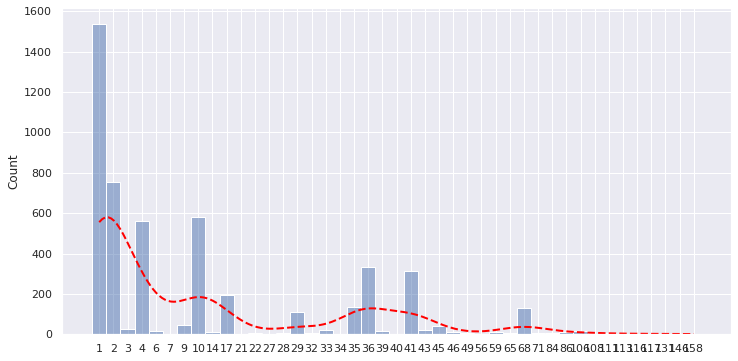

In [18]:
sns.set(rc={'figure.figsize':(12,6)})
Gene = "CYP2D6"
all_star_dict, all_rs_dict = file_calling(Gene, PERSON_ID_all)   
stat(all_star_dict)

In [37]:
# white_star_dict, white_rs_dict = file_calling(Gene, PERSON_ID_white)   
# stat(white_star_dict)

In [38]:
# black_star_dict, black_rs_dict = file_calling(Gene, PERSON_ID_black)   
# stat(black_star_dict)

In [39]:
# sns.set(rc={'figure.figsize':(12,6)})
# asian_star_dict, asian_rs_dict = file_calling(Gene, PERSON_ID_asian)   
# stat(asian_star_dict)


In [40]:
# none_star_dict, none_rs_dict = file_calling(Gene, PERSON_ID_none)   
# stat(none_star_dict)

In [41]:
# multiple_star_dict, multiple_rs_dict = file_calling(Gene, PERSON_ID_multiple)   
# stat(multiple_star_dict)

# Novel Allele Finding

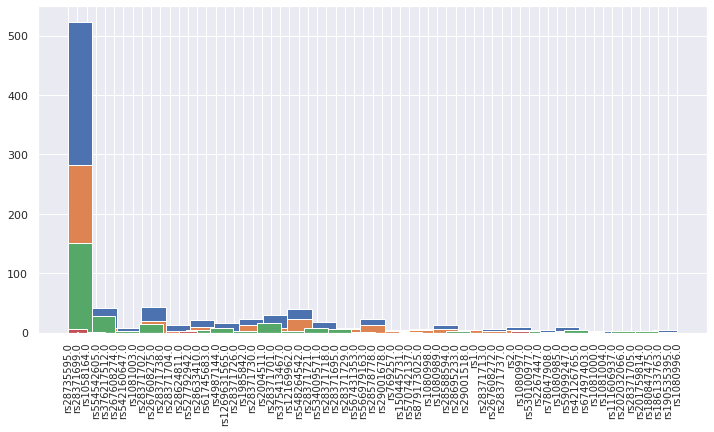

In [273]:
stat(all_rs_dict)
stat(white_rs_dict)
stat(black_rs_dict)
stat(asian_rs_dict)
stat(multiple_rs_dict)

In [32]:
# L = list(itertools.chain.from_iterable(list(all_rs_dict.values())))
# print(Counter(L))
# L = list(itertools.chain.from_iterable(list(white_rs_dict.values())))
# print(Counter(L))
# L = list(itertools.chain.from_iterable(list(black_rs_dict.values())))
# print(Counter(L))
# L = list(itertools.chain.from_iterable(list(asian_rs_dict.values())))
# print(Counter(L))

In [33]:
# L = list(itertools.chain.from_iterable(list(white_rs_dict.values())))
# print(Counter(L))

In [19]:
## CYP2D6 
## the most frequent rs : rs28735595.0, rs28371699.0
## Find star allele which includes additional muatation at "rs28735595.0" or "rs28371699.0"


def keyfind (star_dict, rs_dict, rs):
    rs_key = []
    for key in rs_dict.keys(): # key = person_id
        if rs in rs_dict[key]:
            rs_key.append(key)

    rs_star = []
    for key in rs_key:
        rs_star.append(star_dict[key])

    L = list(itertools.chain.from_iterable(rs_star))
    L = [str(math.floor(x)) for x in L]
    L.sort(key=int)
    
    return L, rs_key



In [20]:
L1_all, L1_rs_key = keyfind(all_rs_dict, all_star_dict, 'rs28735595.0') 
L2_all, L2_rs_key = keyfind(all_rs_dict, all_star_dict, 'rs28371699.0')
# L1_white = keyfind_1(white_rs_dict, white_star_dict)
# L2_white = keyfind_2(white_rs_dict, white_star_dict)
# L1_black = keyfind_1(black_rs_dict, black_star_dict)
# L2_black = keyfind_2(black_rs_dict, black_star_dict)
# L1_asian = keyfind_1(asian_rs_dict, asian_star_dict)
# L2_asian  = keyfind_2(asian_rs_dict, asian_star_dict)
# L1_multiple = keyfind_1(multiple_rs_dict, multiple_star_dict)
# L2_multiple = keyfind_2(multiple_rs_dict, multiple_star_dict)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 3.  ,  3.84,  4.68,  5.52,  6.36,  7.2 ,  8.04,  8.88,  9.72,
        10.56, 11.4 , 12.24, 13.08, 13.92, 14.76, 15.6 , 16.44, 17.28,
        18.12, 18.96, 19.8 , 20.64, 21.48, 22.32, 23.16, 24.  ]),
 <BarContainer object of 25 artists>)

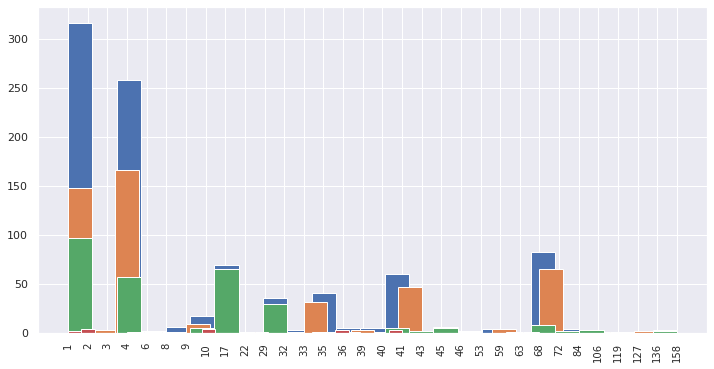

In [300]:
# plt.xticks(rotation='vertical',fontsize=10)
# plt.hist(L1_all, bins=25)
# plt.hist(L1_white, bins=25)
# plt.hist(L1_black, bins=25)
# plt.hist(L1_asian, bins=25)
# plt.hist(L1_multiple, bins=25)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  """


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 2.]),
 array([ 3.  ,  3.52,  4.04,  4.56,  5.08,  5.6 ,  6.12,  6.64,  7.16,
         7.68,  8.2 ,  8.72,  9.24,  9.76, 10.28, 10.8 , 11.32, 11.84,
        12.36, 12.88, 13.4 , 13.92, 14.44, 14.96, 15.48, 16.  ]),
 <BarContainer object of 25 artists>)

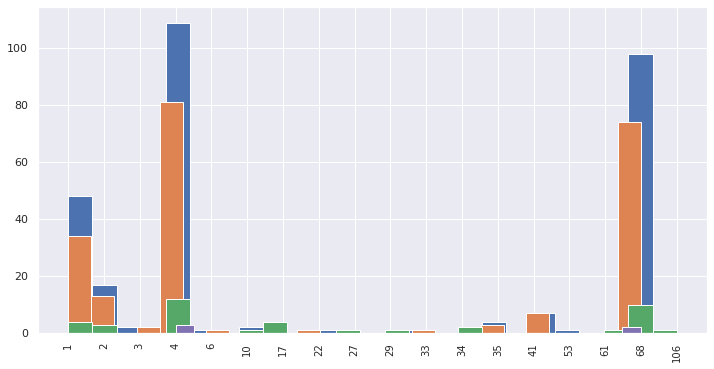

In [301]:
# plt.xticks(rotation='vertical',fontsize=10)
# plt.hist(L2_all, bins=25)
# plt.hist(L2_white, bins=25)
# plt.hist(L2_black, bins=25)
# plt.hist(L2_asian, bins=25)
# plt.hist(L2_multiple, bins=25)


# Extract Samples
Find samples which have a very frequent but uncategorized alleles

Additional muation at 'rs28735595.0' was frequently found with *1, *4

Additional muation at 'rs28371699.0' was frequently found with *1, *4, *68

In [14]:
def sample_extract(star_dict, rs_dict, allele, rs):
# -------------------------------------
# 1. star_dict : dictionary
# 2. rs_dict : dictionary
# 3. allele : int type star allele
# 4. rs : string type rs position
# -------------------------------------
    
    L, L_rs_key = keyfind(star_dict, rs_dict, rs) 
    
    key_list = []
    for key in L_rs_key:
        allele_in_this_person = list(map(math.floor,star_dict[key]))
        if allele in allele_in_this_person:
            key_list += [key]
            
    return key_list

In [21]:
# Samples <'rs28735595.0' + *1/*4>
L1_1 = sample_extract(CYP2D6_id_star_dict, CYP2D6_id_rs_dict, 1, 'rs28735595.0' )
L1_4 = sample_extract(CYP2D6_id_star_dict, CYP2D6_id_rs_dict, 4, 'rs28735595.0' )

# Samples <'rs28371699.0' + *1/*4/*68>
L2_1 = sample_extract(CYP2D6_id_star_dict, CYP2D6_id_rs_dict, 1, 'rs28371699.0' )
L2_4 = sample_extract(CYP2D6_id_star_dict, CYP2D6_id_rs_dict, 4, 'rs28371699.0' )
L2_68 = sample_extract(CYP2D6_id_star_dict, CYP2D6_id_rs_dict, 4, 'rs28371699.0' )

In [22]:
pd.DataFrame({'person_id':L1_1}).to_csv("./novel_allele_finding/rs28735595_*1.csv")
pd.DataFrame({'person_id':L1_4}).to_csv("./novel_allele_finding/rs28735595_*4.csv")
pd.DataFrame({'person_id':L2_1}).to_csv("./novel_allele_finding/rs28371699_*1.csv")
pd.DataFrame({'person_id':L2_4}).to_csv("./novel_allele_finding/rs28371699_*4.csv")
pd.DataFrame({'person_id':L2_68}).to_csv("./novel_allele_finding/rs28371699_*68.csv")